In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from scipy.ndimage import zoom

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_path = "C:/Users/HP/Downloads/GLEASON/Train_with_Gleason_and_Labels.csv"
df = pd.read_csv(csv_path)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join('C:/Users/HP/Downloads/GLEASON/Train Imgs', os.path.basename(x)))
df['mask_path'] = df['mask_path'].apply(lambda x: os.path.join('C:/Users/HP/Downloads/GLEASON/', x.strip('./')))

def remap_risk_label(label):
    if label in [0, 1]:
        return 0
    elif label == 2:
        return 1
    elif label == 3:
        return 2
    else:
        return -1

df['risk_class'] = df['risk_label'].apply(remap_risk_label)
df = df[df['risk_class'] != -1]

In [3]:
# === Split ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['risk_class'], random_state=42)

# === SegFormer Setup ===
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
segformer = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=3,
    ignore_mismatched_sizes=True
).to(device)

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the 

In [4]:
class GleasonSegDataset(Dataset):
    def __init__(self, dataframe, feature_extractor):
        self.df = dataframe.reset_index(drop=True)
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.df.loc[idx, 'image_path']).convert("RGB")
        mask = Image.open(self.df.loc[idx, 'mask_path']).convert("L")
        mask = mask.resize((512, 512), resample=Image.NEAREST)
        mask_np = np.array(mask)
        remap = np.zeros_like(mask_np)
        remap[mask_np == 3] = 0
        remap[mask_np == 4] = 1
        remap[mask_np == 5] = 2

        inputs = self.feature_extractor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(remap, dtype=torch.long)
        return inputs

train_segset = GleasonSegDataset(train_df, feature_extractor)
val_segset = GleasonSegDataset(val_df, feature_extractor)

train_segloader = DataLoader(train_segset, batch_size=4, shuffle=True)
val_segloader = DataLoader(val_segset, batch_size=4)

In [8]:
optimizer = optim.Adam(segformer.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    segformer.train()
    total_loss = 0
    for batch in tqdm(train_segloader, desc=f"SegFormer Epoch {epoch+1}"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)

        outputs = segformer(**inputs)
        logits = outputs.logits  # shape: [B, 3, H', W']

        # === Resize labels to match logits spatial dims ===
        if labels.shape[-2:] != logits.shape[-2:]:
            labels = torch.nn.functional.interpolate(
                labels.unsqueeze(1).float(), 
                size=logits.shape[-2:], 
                mode="nearest"
            ).squeeze(1).long()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"SegFormer Epoch {epoch+1} Loss: {total_loss:.4f}")

segformer.save_pretrained("segformer_finetuned")
feature_extractor.save_pretrained("segformer_finetuned")

SegFormer Epoch 1: 100%|█████████████████████████████████████████████████████████████| 234/234 [32:02<00:00,  8.21s/it]


SegFormer Epoch 1 Loss: 147.5161


SegFormer Epoch 2: 100%|█████████████████████████████████████████████████████████████| 234/234 [32:36<00:00,  8.36s/it]


SegFormer Epoch 2 Loss: 99.7407


SegFormer Epoch 3: 100%|█████████████████████████████████████████████████████████████| 234/234 [32:03<00:00,  8.22s/it]


SegFormer Epoch 3 Loss: 87.6879


SegFormer Epoch 4: 100%|█████████████████████████████████████████████████████████████| 234/234 [30:26<00:00,  7.80s/it]


SegFormer Epoch 4 Loss: 82.3818


SegFormer Epoch 5: 100%|█████████████████████████████████████████████████████████████| 234/234 [30:01<00:00,  7.70s/it]


SegFormer Epoch 5 Loss: 79.9323


['segformer_finetuned\\preprocessor_config.json']

In [10]:
!pip install seaborn timm

     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
     -------- ---------------------------- 71.7/294.9 kB 787.7 kB/s eta 0:00:01
     ------------------------- ------------ 194.6/294.9 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     --- ------------------------------------ 0.2/2.5 MB 7.6 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/2.5 MB 5.6 MB/s eta 0:00:01
     ------------- -------------------------- 0.8/2.5 MB 5.7 MB/s eta 0:00:01
     ---------------- ----------------------- 1.0/2.5 MB 5.4 MB/s eta 0:00:01
     -------------------- ------------------- 1.3/2.5 MB 5.9 MB/s eta 0:00:01
     ------------------------ --------------- 1.5/2.5 MB 5.7 MB/s eta 0:00:01
     ---------------------------- ----------- 1.8/2.5 MB 6.0 MB/s eta 0:00


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import seaborn as sns
import timm

In [12]:
output_dir = "segformer_outputs"
os.makedirs(output_dir, exist_ok=True)
segformer.eval()

for i in tqdm(range(len(df))):
    image = Image.open(df.loc[i, 'image_path']).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = segformer(**inputs).logits
    seg = logits.argmax(dim=1)[0].cpu().numpy()
    seg_resized = zoom(seg, (224 / seg.shape[0], 224 / seg.shape[1]), order=0)
    Image.fromarray(np.uint8(seg_resized)).save(os.path.join(output_dir, f"mask_{i:03d}.png"))

100%|██████████████████████████████████████████████████████████████████████████████| 1171/1171 [24:55<00:00,  1.28s/it]


In [13]:
# === Combined Dataset with 5 Channels ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [14]:
class Prostate5ChannelDataset(Dataset):
    def __init__(self, dataframe, seg_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.seg_dir = seg_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        patho_mask = Image.open(row['mask_path']).convert('L')
        seg_mask = Image.open(os.path.join(self.seg_dir, f"mask_{idx:03d}.png")).convert('L')

        image = self.transform(image)
        patho_mask = self.transform(patho_mask)
        seg_mask = self.transform(seg_mask)

        combined = torch.cat([image, patho_mask, seg_mask], dim=0)
        label = torch.tensor(row['risk_class']).long()
        return combined, label

train_dataset = Prostate5ChannelDataset(train_df, output_dir, transform)
val_dataset = Prostate5ChannelDataset(val_df, output_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [15]:
class EfficientNet5Channel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=3):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, in_chans=5, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [18]:
def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            pred = outputs.argmax(1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
    disp.plot(cmap="Blues")
    plt.title("Validation Confusion Matrix")
    plt.show()
    return acc, f1

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:34<00:00,  9.74s/it]


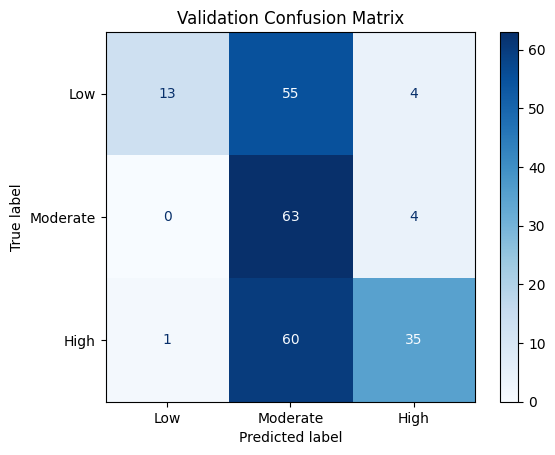

Epoch 1: Loss=177.1036, Acc=0.4723, F1=0.4450
Best model saved.


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [10:19<00:00, 10.51s/it]


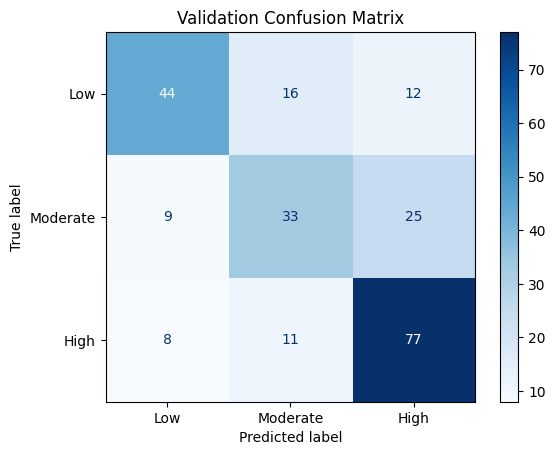

Epoch 2: Loss=66.6365, Acc=0.6553, F1=0.6505
Best model saved.


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:17<00:00,  9.45s/it]


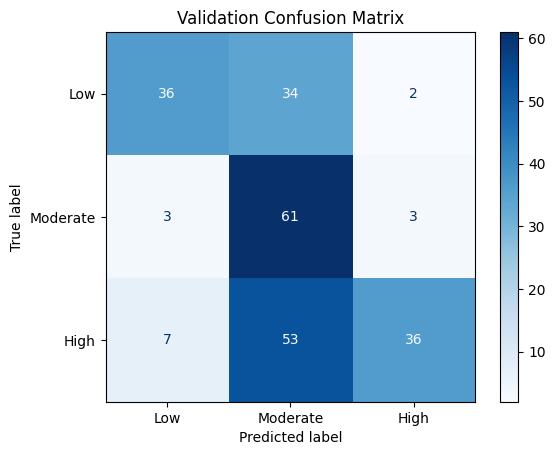

Epoch 3: Loss=43.8935, Acc=0.5660, F1=0.5634


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:10<00:00,  9.33s/it]


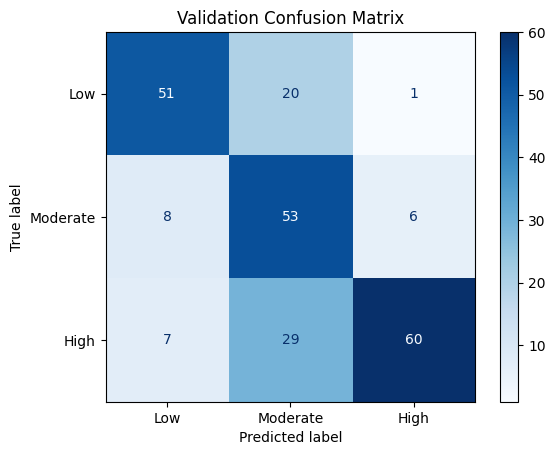

Epoch 4: Loss=36.9755, Acc=0.6979, F1=0.7060
Best model saved.


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:09<00:00,  9.31s/it]


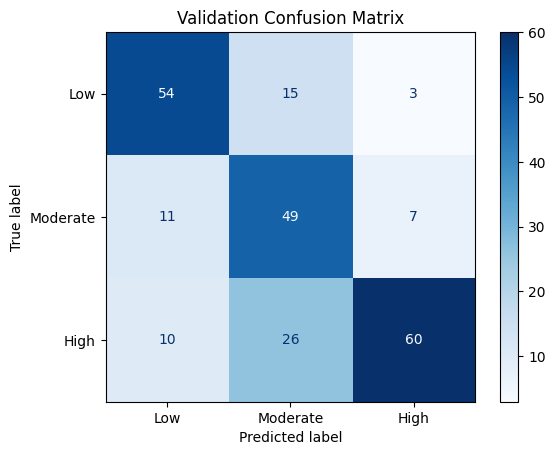

Epoch 5: Loss=35.0462, Acc=0.6936, F1=0.6984


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:14<00:00,  9.39s/it]


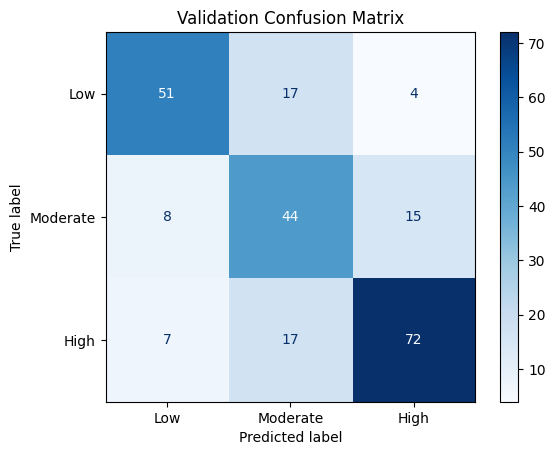

Epoch 6: Loss=31.9347, Acc=0.7106, F1=0.7141
Best model saved.


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:30<00:00,  9.67s/it]


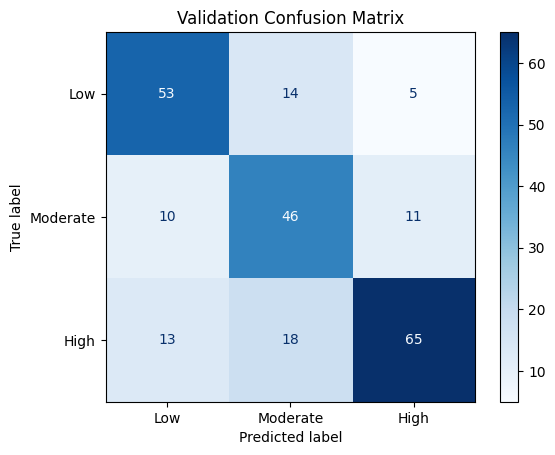

Epoch 7: Loss=31.8834, Acc=0.6979, F1=0.7004


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:11<00:00,  9.34s/it]


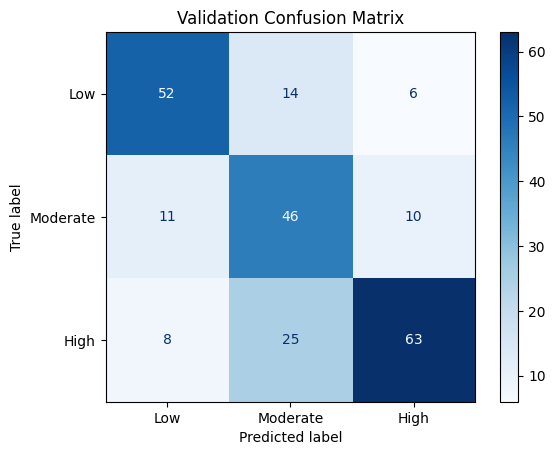

Epoch 8: Loss=30.6313, Acc=0.6851, F1=0.6895


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [09:13<00:00,  9.38s/it]


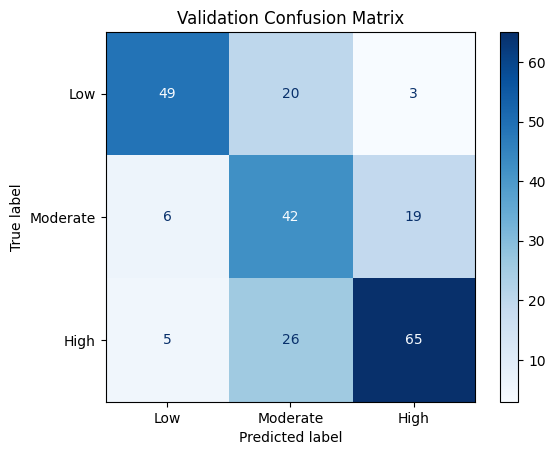

Epoch 9: Loss=31.7525, Acc=0.6638, F1=0.6722
Early stopping.


In [19]:
model = EfficientNet5Channel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
class_counts = torch.tensor([356, 336, 479], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
best_f1, patience, wait = 0, 3, 0

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    acc, f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model_efficientnet_multiclass.pt")
        print("Best model saved.")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break